In [1]:
import gc
import cv2
import h5py
import tomopy
import xraylib
import tifffile as tiff
import dxchange
import cupy as cp
import numpy as np
import tomocg as pt
import matplotlib.pyplot as plt 

astropy module not found


In [5]:
print(tomopy.__file__)

/home/m_fokin/anaconda3/envs/xray/lib/python3.8/site-packages/tomopy/__init__.py


# 1. Fuctions definition 

In [2]:
def wavelength(energy):
    """Return the wavelength [cm] for a given energy [keV]."""
    return 2 * np.pi * PLANCK_CONSTANT * SPEED_OF_LIGHT / energy


def wavenumber(energy):
    """Return the wavenumber [1/cm] given energy [keV]."""
    return energy / PLANCK_CONSTANT / SPEED_OF_LIGHT


def exptomo(pixel_size, beta, energy):
    """ Exp representation of projections """
    return np.exp(-2 * wavenumber(energy) * pixel_size * beta)


def complex_refr_index(compound, energy, density):
    Re = xraylib.Refractive_Index_Re(compound = compound, E = energy, density = density)
    Im = xraylib.Refractive_Index_Im(compound = compound, E = energy, density = density)
    return (1 - Re, Im)


def sphere_mask(mesh_size, center, radius, dtype):
    X, Y, Z = np.ogrid[:mesh_size[0], :mesh_size[1], :mesh_size[2]]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2 + (Z-center[2])**2, dtype = np.float32)
    mask = np.zeros(mesh_size, dtype = dtype)
    for r in range(len(radius)):
        mask_tmp = dist_from_center <= radius[r]
        mask += np.uint8(mask_tmp)     
    return mask


def radon_gpu (u0, n , nz, ntheta, center, theta, pnz, ngpus):
    with pt.SolverTomo(theta, ntheta, nz, n, pnz, center, ngpus) as slv:
            # generate data
            data = slv.fwd_tomo_batch(u0)
    return (data.real, data.imag)


def binning(data, level):
    data = tomopy.downsample(data, level=level, axis=2) 
    data = tomopy.downsample(data, level=level, axis=1)
    return data


def propagate_tie(beta, delta, energy, pixel_size, dist):
    """
    Propagate emitting x-ray wave based on Transport of Intensity.
    Parameters
    ----------
    beta : ndarray, optional
        3D tomographic data for real part .
    delta : ndarray
        3D tomographic data for refractive index.
    pixel_size : float
        Detector pixel size in cm.
    dist : float
        Propagation distance of the wavefront in cm.
    Returns
    -------
    ndarray
        3D propagated tomographic intensity.
    """
    i1 = exptomo(pixel_size = pixel_size , beta = beta, energy = energy)
    i2 = np.zeros(delta.shape)
    
    for m in range(delta.shape[0]):
        dx, dy = np.gradient(delta[m] * pixel_size, pixel_size)
        d2x, _ = np.gradient(i1[m] * dx, pixel_size)
        _, d2y = np.gradient(i1[m] * dy, pixel_size)
        i2[m] = i1[m] + dist * (d2x + d2y)
    return i2


def RI_mix(energy, m_frac_H2O = 0.9, m_frac_NaBr = 0.1):
    
    w_H2O = 18.01528 # [g/mol]
    w_NaBr = 102.894 # [g/mol]
    
    w_mix = m_frac_H2O * w_H2O + m_frac_NaBr * w_NaBr
    
    mol_frac_H2O = m_frac_H2O * w_H2O / w_mix
    mol_frac_NaBr = m_frac_NaBr * w_NaBr / w_mix
    
    delta_H2O = 1 - xraylib.Refractive_Index_Re("H2O", energy, 1)
    delta_NaBr = 1 - xraylib.Refractive_Index_Re("NaBr",energy, 1.251)
    delta_mix = delta_H2O * mol_frac_H2O + delta_NaBr * mol_frac_NaBr
    
    beta_H2O = xraylib.Refractive_Index_Im("H2O", energy, 1)
    beta_NaBr = xraylib.Refractive_Index_Im("NaBr",energy, 1.251)
    beta_mix = beta_H2O * mol_frac_H2O + beta_NaBr * mol_frac_NaBr
    
    return (delta_mix, beta_mix)

In [3]:
print(complex_refr_index('C4H8O8H2O136', 35, 0.97)[0])
print(complex_refr_index('C4H8O8H2O136', 35, 0.97)[1])
print(complex_refr_index('C4H8O8H2O136', 35, 0.97)[0]/complex_refr_index('C4H8O8H2O136', 35, 0.97)[1])

1.6506939137794774e-07
8.219867221756081e-11
2008.1758856280228


# 2.  Example

## 2.1 params definition

In [4]:
PLANCK_CONSTANT = 6.58211928e-19  # [keV*s]
SPEED_OF_LIGHT = 299792458e+2  # [cm/s]

# sample size [px]
sample_size = [512, 512, 512]

# center of sample rotation [px]
center = [256, 256, 256]

# number of rotation angles [1]
n_angles = 256 

# pixel size [cm]
pixel_size = 1e-3

In [5]:
print('SiO2: ',complex_refr_index("SiO2",21.0,2.65)[1]) 
print('H2O: ',complex_refr_index("H2O", 21.0, 1)[1])

SiO2:  2.7676264713571698e-09
H2O:  3.407495879927353e-10


## 2.2 Make phantom 

In [11]:
# methane refractive index 
delta_m = complex_refr_index("CH4", 21.0, 0.00055)[0]
beta_m = complex_refr_index("CH4", 21.0, 0.00055)[1]

# quartz recractive index 
delta_c = complex_refr_index("SiO2", 21.0, 2.65)[0]
beta_c = complex_refr_index("SiO2",21.0,2.65)[1]

# water refractive index
delta_w = complex_refr_index("H2O", 21.0, 1)[0]
beta_w = complex_refr_index("H2O", 21.0, 1)[1]

print("CH4 Refractive Index at 21.0 keV : {} - {} i".format(delta_m, beta_m))
print("SiO2 Refractive Index at 21.0 keV : {} - {} i".format(delta_c, beta_c))
print("H2O Refractive Index at 21.0 keV : {} - {} i".format(delta_w, beta_w))
                  
delta = sphere_mask(mesh_size = sample_size, center = center, 
                    radius = [128, 140], dtype = np.float32) 

beta = sphere_mask(mesh_size = sample_size, center = center, 
                    radius = [128, 140], dtype = np.float32) 

delta[np.where(delta == 0)] = delta_m
beta[np.where(beta == 0)] = beta_m

delta[np.where(delta == 1)] = delta_w
beta[np.where(beta == 1)] = beta_w

delta[np.where(delta == 2)] = delta_c
beta[np.where(beta == 2)] = beta_c

for i in range (delta.shape[0]):                
    delta[i,:,:] = cv2.GaussianBlur(delta[i,:,:],(7,7),0).astype(np.float32)
    beta[i,:,:] = cv2.GaussianBlur(beta[i,:,:],(7,7),0).astype(np.float32)

CH4 Refractive Index at 21.0 keV : 3.2266878058351267e-10 - 1.0248038879833976e-13 i
SiO2 Refractive Index at 21.0 keV : 1.2485900948711048e-06 - 2.7676264713571698e-09 i
H2O Refractive Index at 21.0 keV : 5.228090673714547e-07 - 3.407495879927353e-10 i


## 2.2 Load phantom from tiff

In [7]:
# methane refractive index 
delta_m = complex_refr_index("CH4", 21.0, 0.00055)[0]
beta_m = complex_refr_index("CH4", 21.0, 0.00055)[1]

# quartz recractive index 
delta_c = complex_refr_index("SiO2", 21.0, 2.65)[0]
beta_c = complex_refr_index("SiO2",21.0,2.65)[1]

# water refractive index
delta_w = complex_refr_index("H2O", 21.0, 1)[0]
beta_w = complex_refr_index("H2O", 21.0, 1)[1]

# H20 + NaBr refractive index 
delta_mix = RI_mix(energy = 21, m_frac_H2O = 0.9, m_frac_NaBr = 0.1)[0]
beta_mix = RI_mix(energy = 21, m_frac_H2O = 0.9, m_frac_NaBr = 0.1)[1]


print("CH4 Refractive Index at 21.0 keV : {} - {} i".format(delta_m, beta_m))
print("SiO2 Refractive Index at 21.0 keV : {} - {} i".format(delta_c, beta_c))
print("H2O Refractive Index at 21.0 keV : {} - {} i".format(delta_w, beta_w))
print("H2O + NaBr Refractive Index at 21.0 keV : {} - {} i".format(delta_mix, beta_mix))
                  
delta =  np.float32(tiff.imread('packing.tiff'))

beta =  np.float32(tiff.imread('packing.tiff'))

delta[np.where(delta == 0)] = delta_m
beta[np.where(beta == 0)] = beta_m

delta[np.where(delta == 10)] = delta_w
beta[np.where(beta == 10)] = beta_w

delta[np.where(delta == 11)] = delta_c
beta[np.where(beta == 11)] = beta_c

for i in range (delta.shape[0]):                
    delta[i,:,:] = cv2.GaussianBlur(delta[i,:,:],(7,7),0).astype(np.float32)
    beta[i,:,:] = cv2.GaussianBlur(beta[i,:,:],(7,7),0).astype(np.float32)

CH4 Refractive Index at 21.0 keV : 3.2266878058351267e-10 - 1.0248038879833976e-13 i
SiO2 Refractive Index at 21.0 keV : 1.2485900948711048e-06 - 2.7676264713571698e-09 i
H2O Refractive Index at 21.0 keV : 5.228090673714547e-07 - 3.407495879927353e-10 i
H2O + NaBr Refractive Index at 21.0 keV : 5.249020967430243e-07 - 8.491006637704552e-09 i


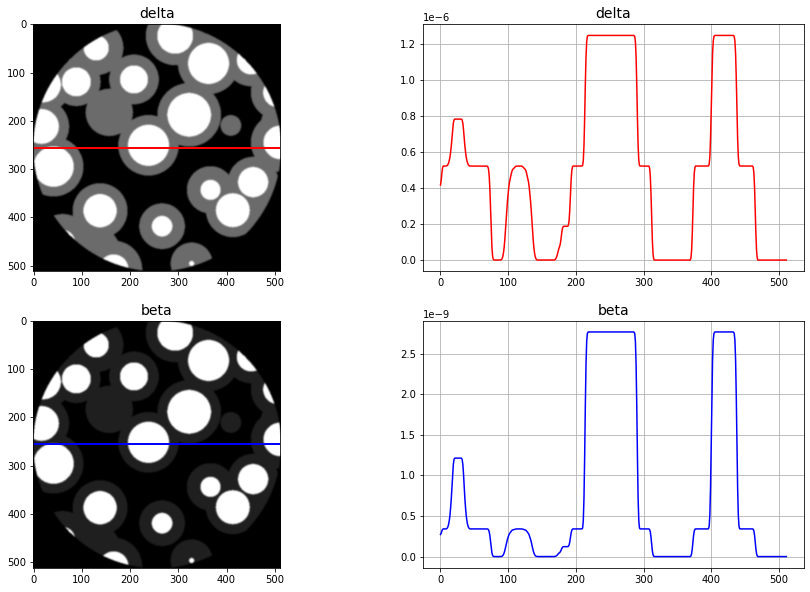

In [8]:
plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.title('delta', fontsize = '14')
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.imshow(delta[sample_size[0]//2,:,:], cmap = 'gray')

plt.subplot(2,2,2)
plt.grid()
plt.title('delta', fontsize = '14')
plt.plot(delta[sample_size[0]//2,:,sample_size[0]//2], color="r")

plt.subplot(2,2,3)
plt.title('beta', fontsize = '14')
plt.plot([0, sample_size[0]], [sample_size[0]/2, sample_size[0]//2], color="b", linewidth=2)
plt.imshow(beta[sample_size[0]//2,:,:], cmap = 'gray')

plt.subplot(2,2,4)
plt.grid()
plt.title('beta', fontsize = '14')
plt.plot(beta[sample_size[0]//2,:,sample_size[0]//2], color="b")

## 2.3 Make radon transform

In [9]:
n = sample_size[0]  # object size in x,y
nz = sample_size[2]  # object size in z
ntheta = sample_size[0]//2  # number of angles (rotations)
center = n/2  # rotation center
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # angles
pnz = 1  # number of slice partitions for simultaneous processing in tomography
    
proj_delta = radon_gpu(delta + 1j*beta, n = n,
                      nz = nz, ntheta = ntheta, pnz = 1, center = center, 
                       theta = theta, ngpus = 1)[0]

proj_beta = radon_gpu(delta + 1j*beta, n = n,
                      nz = nz, ntheta = ntheta, pnz = 1, center = center, 
                       theta = theta, ngpus = 1)[1]

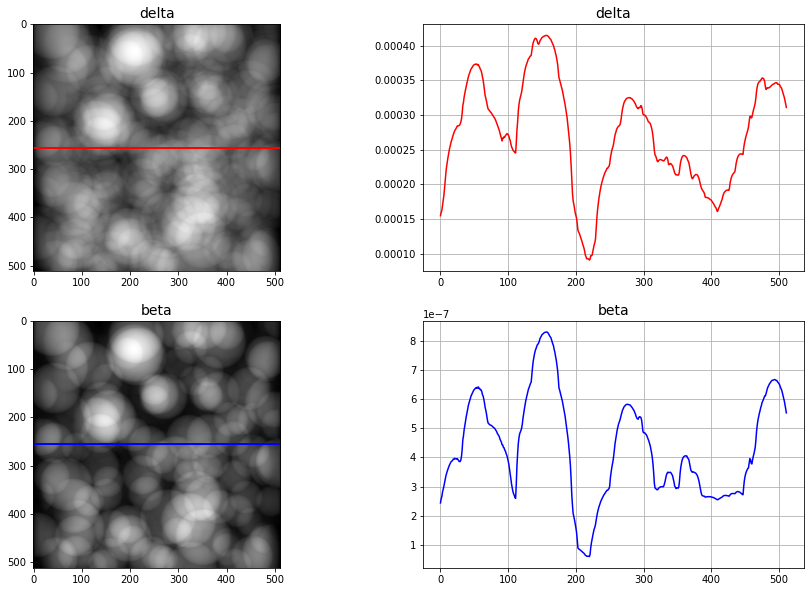

In [10]:
plt.figure(figsize = (15, 10))

plt.subplot(2,2,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.title('delta', fontsize = '14')
plt.imshow(proj_delta[0,:,:], cmap = 'gray')

plt.subplot(2,2,2)
plt.grid()
plt.title('delta', fontsize = '14')
plt.plot(proj_delta[0,:,sample_size[0]//2], color="r")


plt.subplot(2,2,3)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="b", linewidth=2)
plt.title('beta', fontsize = '14')
plt.imshow(proj_beta[0,:,:], cmap = 'gray')

plt.subplot(2,2,4)
plt.grid()
plt.title('beta', fontsize = '14')
plt.plot(proj_beta[0,:,sample_size[0]//2], color="b")

In [11]:
del delta
del beta 
gc.collect()

36

## 2.4 Solve TIE

In [12]:
proj_tie = propagate_tie(beta = proj_beta, delta = proj_delta, energy = 21, pixel_size = pixel_size, dist = 10)

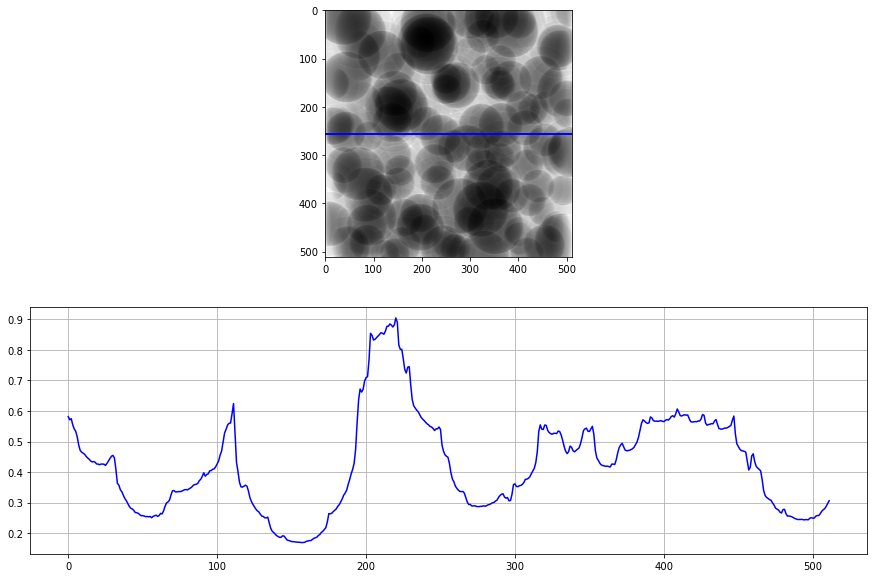

In [13]:
plt.figure(figsize = (15, 10))

plt.subplot(2,1,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="b", linewidth=2)
plt.imshow(proj_tie[0,:,:], cmap = 'gray')

plt.subplot(2,1,2)
plt.grid()
plt.plot(proj_tie[0,:,sample_size[0]//2], color="b")

## 2.5 Make preprocessing

### 2.5.1 Retrieve phase

In [14]:
proj = binning(proj_tie, 0)

In [20]:
proj = tomopy.retrieve_phase(tomo = proj, pixel_size=pixel_size, dist= 10, energy=21, alpha=0.0009, pad=True, ncore=16, nchunk=20)

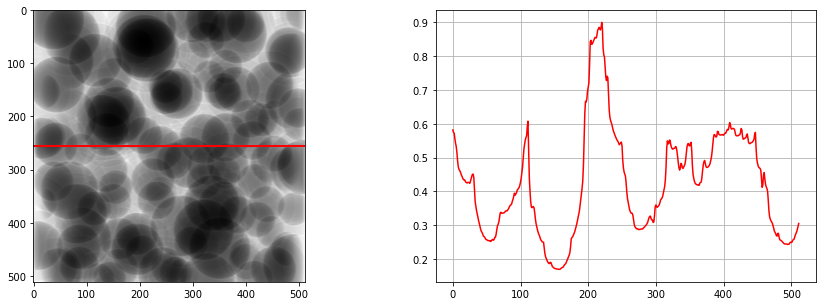

In [21]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.imshow(proj[0,:,:], cmap = 'gray')

plt.subplot(1,2,2)
plt.grid()
plt.plot(proj[0,:,sample_size[0]//2], color="r")

### 2.5.2  Linearization

In [22]:
proj = tomopy.minus_log(proj)

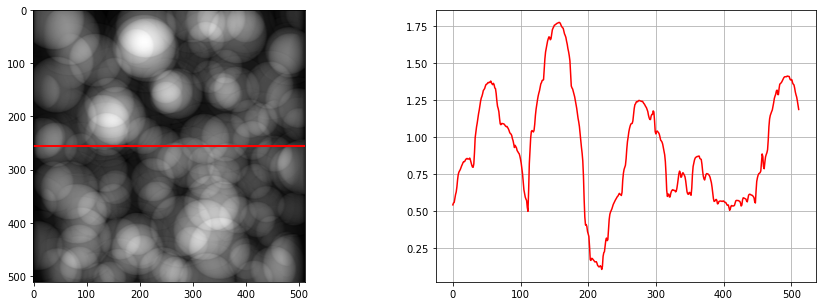

In [23]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.imshow(proj[0,:,:], cmap = 'gray')

plt.subplot(1,2,2)
plt.grid()
plt.plot(proj[0,:,sample_size[0]//2], color="r")

### 2.5.3 Compare calculated projections with TIE result at z =0 

In [24]:
proj_0 = propagate_tie(beta = proj_beta, delta = proj_delta, energy = 21, pixel_size = pixel_size, dist = 0)
proj_0 = tomopy.minus_log(proj_0)

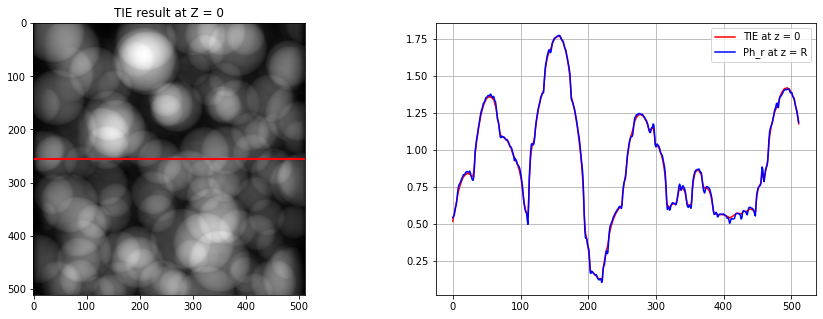

In [25]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.title('TIE result at Z = 0')
plt.imshow(proj_0[0,:,:], cmap = 'gray')

plt.subplot(1,2,2)
plt.grid()
plt.plot(proj_0[0,:,sample_size[0]//2], color="r", label = 'TIE at z = 0')
plt.plot(proj[0,:,sample_size[0]//2], color="b", label = 'Ph_r at z = R')
plt.legend()

## 2.6 Reconstruction

In [26]:
rotation_axis = center

proj = proj_0

N = proj.shape[2]
proj_pad = np.zeros([proj.shape[0],proj.shape[1],3*N//2],dtype = "float32")
proj_pad[:,:,N//4:5*N//4] = proj
proj_pad[:,:,0:N//4] = np.reshape(proj[:,:,0],[proj.shape[0],proj.shape[1],1])
proj_pad[:,:,5*N//4:] = np.reshape(proj[:,:,-1],[proj.shape[0],proj.shape[1],1])
rot_center = rotation_axis + N//4

recon = tomopy.recon(proj_pad, theta = theta, center=rot_center, sinogram_order=False, algorithm = 'gridrec', ncore=16, nchunk=None)
recon = recon[:,N//4:5*N//4,N//4:5*N//4]

512
16
Reconstructing 16 slice groups with 16 master threads...


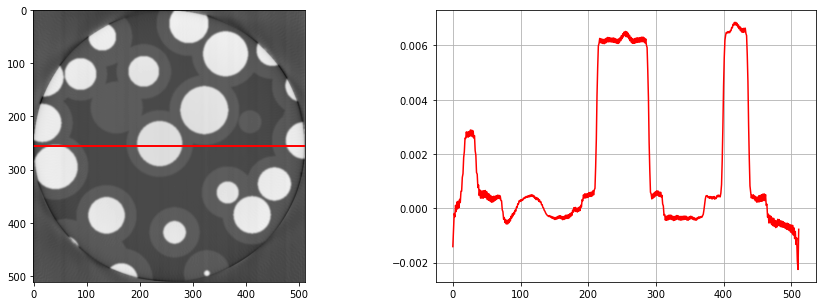

In [27]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.imshow(recon[sample_size[0]//2,:,:], cmap = 'gray')

plt.subplot(1,2,2)
plt.grid()
plt.plot(recon[256,:,256], color="r")

In [43]:
test = add_phase(tomo = recon, pixel_size=pixel_size, dist= 10, energy=21, alpha=0.0003, pad=True, ncore=16, nchunk=20)

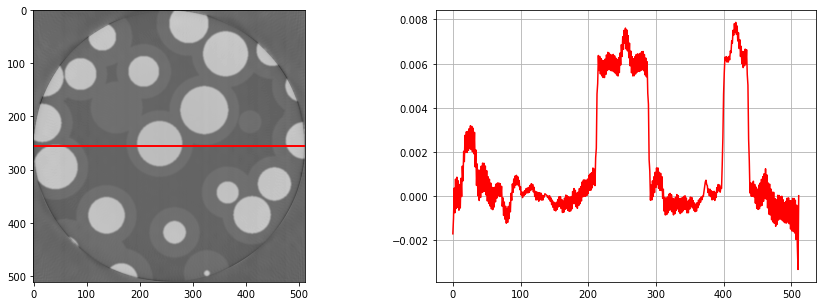

In [44]:
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
plt.plot([0, sample_size[0]], [sample_size[0]//2, sample_size[0]//2], color="r", linewidth=2)
plt.imshow(test[sample_size[0]//2,:,:], cmap = 'gray')

plt.subplot(1,2,2)
plt.grid()
plt.plot(test[256,:,256], color="r")

In [ ]:
tiff.imsave('recon2.tiff', recon)

## 2.7 Calc_histogram

In [ ]:
img = recon[sample_size[0]//2,:,:]
img = img - img.min()
img = np.uint8(img * (255/img.max()))
img = tomopy.sim.project.add_poisson(img)
img = img.astype(np.float32)

In [ ]:
radius = 256
mesh_size = [512, 512]
center = [256, 256]
dtype = np.uint8

X, Y = np.ogrid[:mesh_size[0], :mesh_size[1]]
dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2, dtype = np.float32)
mask = np.zeros(mesh_size, dtype = dtype)
mask = dist_from_center <= radius  

In [ ]:
a = mask.astype(np.uint8)

In [ ]:
import cv2 

histSize = 256
histRange = (0, 256) # the upper boundary is exclusive
accumulate = False
hist = cv2.calcHist([img], [0], a, [histSize], histRange, accumulate=accumulate)

In [ ]:
plt.grid()
plt.plot(hist)

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(img, cmap = 'gray')

In [ ]:
a = 4 * np.pi / wavelength(21)

plt.figure(figsize = (15, 5))
plt.grid()

plt.plot(recon[256,:,256], color="r")

plt.plot(beta[256,:,256] * a / 1000, color="b")

# 3. Water film simulation

In [ ]:
PLANCK_CONSTANT = 6.58211928e-19  # [keV*s]
SPEED_OF_LIGHT = 299792458e+2  # [cm/s]

# sample size [px]
sample_size = [1024, 1024, 1024]

# number of rotation angles [1]
n_angles = 512

# pixel size [cm]
pixel_size = 1e-4

# object size in x,y
n = sample_size[0] 

 # object size in z
nz = sample_size[2] 

# number of angles (rotations)
ntheta = sample_size[0]//2  

# rotation center
center = n/2 

 # angles
theta = np.linspace(0, np.pi, ntheta).astype('float32') 

# number of slice partitions for simultaneous processing in tomography
pnz = 1  
    
# methane refractive index 
delta_m = complex_refr_index("CH4", 21.0, 0.00055)[0]
beta_m = complex_refr_index("CH4", 21.0, 0.00055)[1]

# carbon recractive index 
delta_c = complex_refr_index("C", 21.0, 2.267)[0]
beta_c = complex_refr_index("C",21.0,2.267)[1]

# water refractive index
delta_w = complex_refr_index("H2O", 21.0, 1)[0]
beta_w = complex_refr_index("H2O", 21.0, 1)[1]

flat = np.ones([10,sample_size[1],sample_size[2]], dtype = np.float32)
dark = np.zeros([10,sample_size[1],sample_size[2]], dtype = np.float32)

for r in range(256, 280): 
    
    print(r)
    
    delta = sphere_mask(mesh_size = sample_size, center = [center, center, center], 
                        radius = [r, 256], dtype = np.float32) 

    beta = sphere_mask(mesh_size = sample_size, center = [center, center, center], 
                        radius = [r, 256], dtype = np.float32) 

    delta[np.where(delta == 1)] = delta_w
    beta[np.where(beta == 1)] = beta_w

    delta[np.where(delta == 2)] = delta_c
    beta[np.where(beta == 2)] = beta_c

    for i in range (delta.shape[0]):                
        delta[i,:,:] = cv2.GaussianBlur(delta[i,:,:],(13,13),0).astype(np.float32)
        beta[i,:,:] = cv2.GaussianBlur(beta[i,:,:],(13,13),0).astype(np.float32)
    
    print("phantom_created")
    
    proj_delta = radon_gpu(delta + 1j*beta, n = n,
                          nz = nz, ntheta = ntheta, pnz = 1, center = center, 
                           theta = theta, ngpus = 1)[0]

    proj_beta = radon_gpu(delta + 1j*beta, n = n,
                          nz = nz, ntheta = ntheta, pnz = 1, center = center, 
                           theta = theta, ngpus = 1)[1]
    
    print("radon_complete")
        
    proj_tie = propagate_tie(beta = proj_beta, delta = proj_delta, energy = 21, pixel_size = pixel_size, dist = 10)
    
    print("TIE_solved")
    
    grad_theta = np.linspace(0, 180, n_angles)
    
    hf = h5py.File("256_" + str(r) + '.h5', 'w')
    hf.create_dataset('exchange/data', data=proj_tie, dtype = np.float32)
    hf.create_dataset('exchange/theta', data=grad_theta, dtype = np.float32)
    hf.create_dataset('exchange/data_white', data=flat, dtype = np.float32)
    hf.create_dataset('exchange/data_dark', data=dark, dtype = np.float32)
    hf.close()
   
    del delta 
    del beta 
    del proj_delta
    del proj_beta 
    del proj_tie
    gc.collect()

# 4. Reconstruction

In [ ]:
for r in range(256, 280):    
    
    print(r)
    
    data, flat, dark, theta = dxchange.read_aps_32id(
        fname='1024/256_' + str(r) + '.h5')
    
    proj = binning(data, 1)
    
    proj = tomopy.retrieve_phase(tomo = proj, pixel_size=2e-4, dist= 10, energy=21, alpha=0.00001, pad=True, ncore=16, nchunk=20)
    proj = tomopy.minus_log(proj)

    rotation_axis = 256

    N = proj.shape[2]
    proj_pad = np.zeros([proj.shape[0],proj.shape[1],3*N//2],dtype = "float32")
    proj_pad[:,:,N//4:5*N//4] = proj
    proj_pad[:,:,0:N//4] = np.reshape(proj[:,:,0],[proj.shape[0],proj.shape[1],1])
    proj_pad[:,:,5*N//4:] = np.reshape(proj[:,:,-1],[proj.shape[0],proj.shape[1],1])
    rot_center = rotation_axis + N//4

    recon = tomopy.recon(proj_pad, theta = theta, center=rot_center, sinogram_order=False, algorithm = 'gridrec', ncore=16, nchunk=None)
    recon = recon[:,N//4:5*N//4,N//4:5*N//4]

    hf = h5py.File('recon.h5', 'a')
    hf.create_dataset('256_' + str(r), data=recon, dtype = np.float32)
    hf.close()
    
    del data
    del proj
    del proj_pad
    del recon
    gc.collect()